In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

Data Processing

In [ ]:
value_df_raw = pd.DataFrame()
for year in range(1, 5):
    value_temp = pd.read_csv(
        f"archiwum_tab_a_202{year}.csv",
        encoding='ISO-8859-1',
        sep=';'
    )[['data', '1USD']]

    value_df_raw = pd.concat([value_df_raw, value_temp], ignore_index=True)

In [ ]:
value_df_raw = value_df_raw.fillna("NaN")
value_df = value_df_raw[value_df_raw['data'].str.isdigit()]
value_df['usd'] = value_df['1USD'].str.replace(',', '.').astype(float)
value_df = value_df[['data', 'usd']]

value_df['data'] = pd.to_datetime(value_df['data'], format='%Y%m%d', errors='coerce')
value_df['data_str'] = value_df['data'].dt.strftime('%Y-%m-%d')

<ipython-input-3-001b81638aec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_df['usd'] = value_df['1USD'].str.replace(',', '.').astype(float)


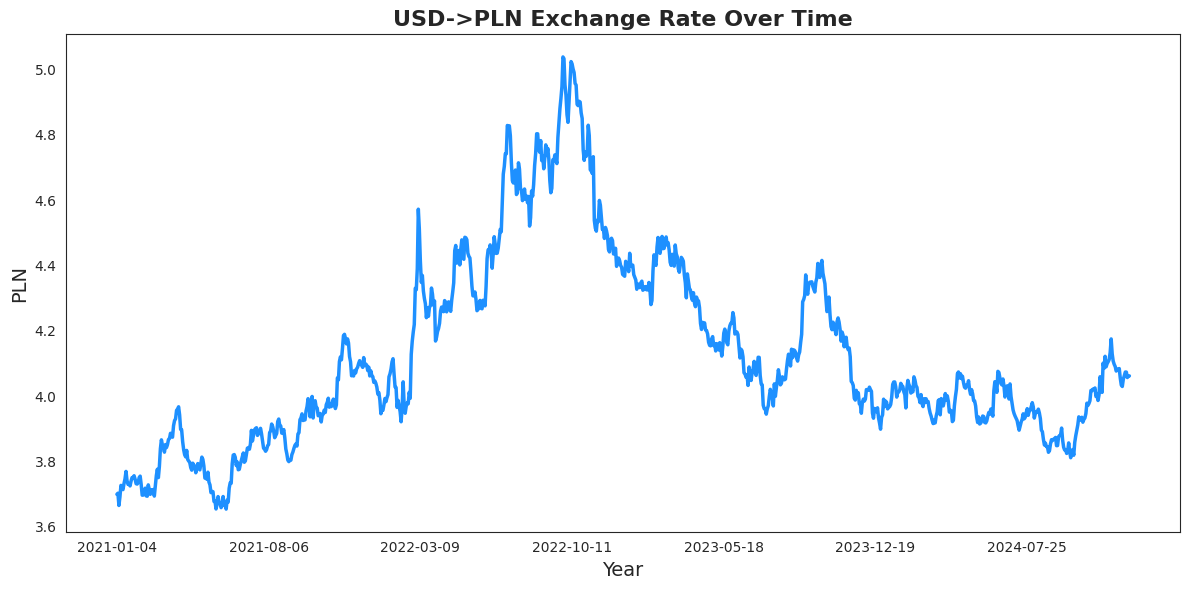

In [ ]:
sns.set_style('white')

plt.figure(figsize=(12, 6))
sns.lineplot(x='data_str', y='usd', data=value_df, color='dodgerblue', linewidth=2.5)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.title('USD->PLN Exchange Rate Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('PLN', fontsize=14)
plt.tight_layout()
plt.show()

Modeling

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(value_df['usd'].values.reshape(-1, 1))

In [ ]:
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0617
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0115
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0088
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0068
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0056
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0052
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0064
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0053
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0046
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0045
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0042
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0050
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0050
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0050
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.004

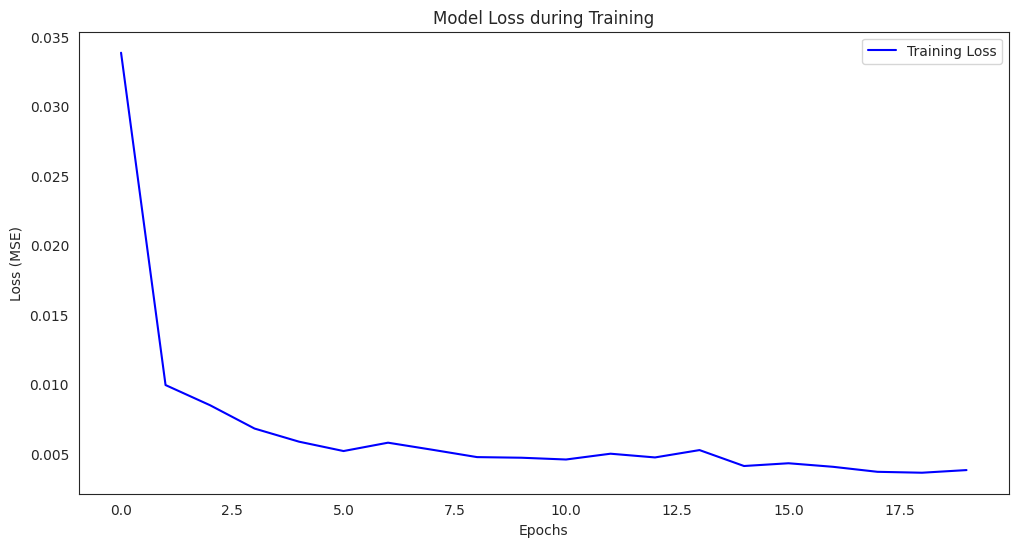

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
predicted_values = model.predict(X_test)

predicted_values = scaler.inverse_transform(predicted_values)
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [ ]:
future_days = 30
last_known_data = scaled_data[-lookback:]
future_predictions = []

for _ in range(future_days):
    future_input = last_known_data.reshape(1, lookback, 1)
    future_pred = model.predict(future_input)
    future_predictions.append(future_pred[0, 0])
    last_known_data = np.append(last_known_data[1:], future_pred)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = value_df['data'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_days + 1)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

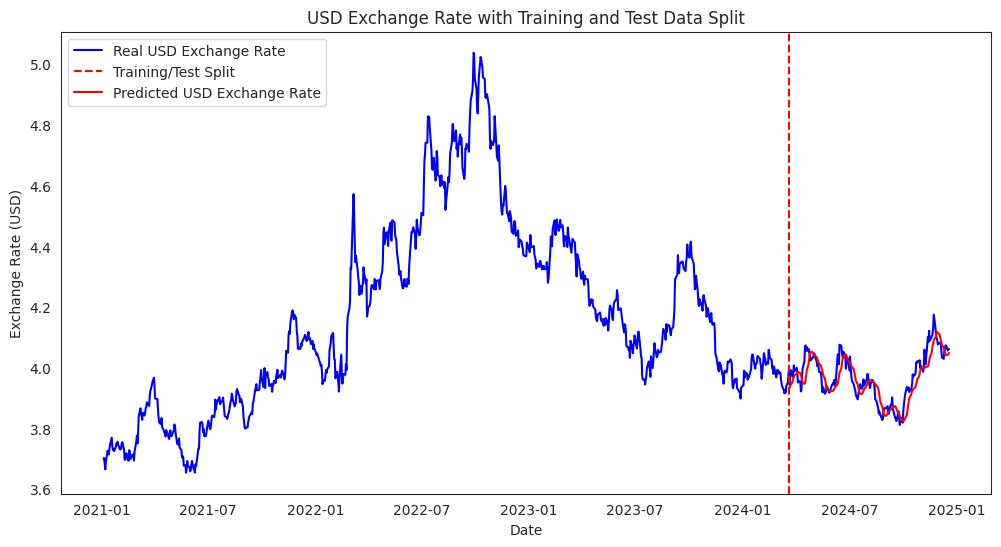

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(value_df['data'], value_df['usd'], color='blue', label='Real USD Exchange Rate')
plt.axvline(x=value_df['data'].iloc[train_size + lookback], color='red', linestyle='--', label='Training/Test Split')
plt.plot(value_df['data'].iloc[train_size + lookback:], predicted_values, color='red', label='Predicted USD Exchange Rate')
plt.title('USD Exchange Rate with Training and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD)')
plt.legend()
plt.show()

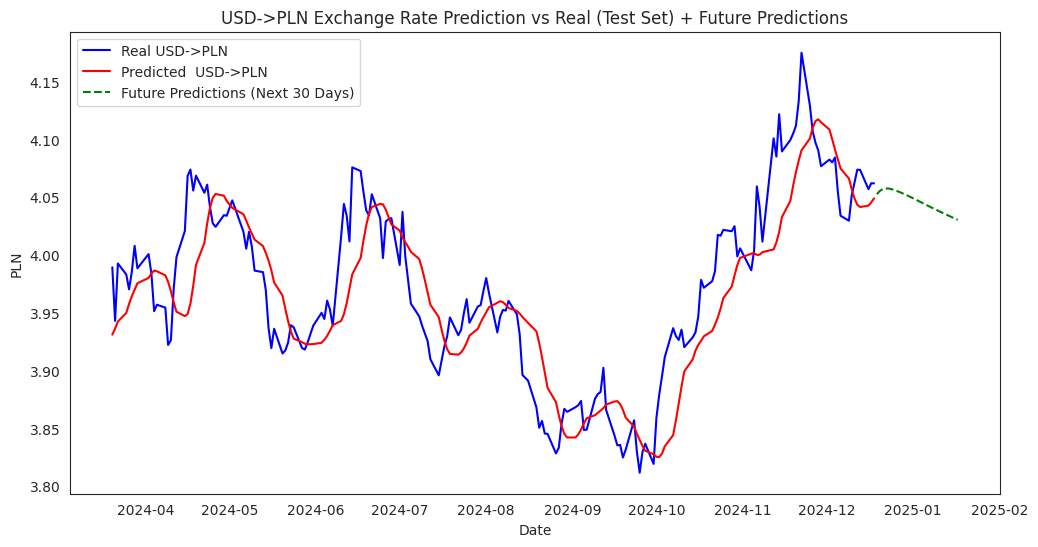

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(value_df['data'].iloc[train_size + lookback:], real_values, color='blue', label='Real USD->PLN')
plt.plot(value_df['data'].iloc[train_size + lookback:], predicted_values, color='red', label='Predicted  USD->PLN')
plt.plot(future_dates, future_predictions, color='green', linestyle='--', label='Future Predictions (Next 30 Days)')
plt.title('USD->PLN Exchange Rate Prediction vs Real (Test Set) + Future Predictions')
plt.xlabel('Date')
plt.ylabel('PLN')
plt.legend()
plt.show()